In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

import numpy as np

import sklearn.preprocessing
import sklearn.model_selection

import pycbc.types
import pycbc.waveform
import pycbc.pnutils
import pycbc.conversions

import lal
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [2]:
import tensorflow as tf
import wispy.callbacks
import tensorflow_addons as tfa

In [3]:
from tf_fourier_features import FourierFeatureProjection

In [4]:
import pycbc.coordinates

In [5]:
def StoM(S, Mtot):
    """StoM(S, Mtot)
    """
    return S / (lal.MTSUN_SI*Mtot)

def MtoS(M, Mtot):
    """MtoS(Hz, Mtot)
    """
    return M * (lal.MTSUN_SI*Mtot)

def td_amp_scale(mtot, distance):
    """
    mtot in solar masses
    distance in m
    M*G/c^2 * M_sun / dist
    """
    return mtot * lal.MRSUN_SI / distance

In [6]:
def generate_waveform(new_times_M, mass_ratio=1, total_mass=100, r_1=0, theta_1=0, phi_1=0, approximant="SEOBNRv4_opt", distance_mpc=1):
    
    mass1=pycbc.conversions.mass1_from_mtotal_q(total_mass, mass_ratio)
    mass2=pycbc.conversions.mass2_from_mtotal_q(total_mass, mass_ratio)
    
    # https://github.com/gwastro/pycbc/blob/master/pycbc/coordinates.py#L117
    spin1x, spin1y, spin1z = pycbc.coordinates.spherical_to_cartesian(r_1, phi_1, theta_1)

    # mass1=pycbc.conversions.mass1_from_mtotal_q(100, 4)
    # mass2=pycbc.conversions.mass2_from_mtotal_q(100, 4)

    # can scale amp by eta
    # eta = pycbc.conversions.eta_from_mass1_mass2(mass1, mass2)

    params = dict(
        # spin1x=mass_ratio,
        mass1=mass1,
        mass2=mass2,
        spin1x=spin1x,
        spin1y=spin1y,
        spin1z=spin1z,
        approximant=approximant,
        f_lower=10,
        delta_t=1/4096,
        distance=distance_mpc
        )
    hp, hc = pycbc.waveform.get_td_waveform(**params)
    delta_t = hp.delta_t

    amp = pycbc.waveform.utils.amplitude_from_polarizations(hp, hc).numpy()
    phase = pycbc.waveform.utils.phase_from_polarizations(hp, hc, remove_start_phase=True).numpy()

    times_M = StoM(hp.sample_times.numpy(), total_mass)

    new_amp = IUS(times_M, amp)(new_times_M)

    distance_m = 1e6*distance_mpc*lal.PC_SI
    new_amp /= td_amp_scale(total_mass, distance_m)

    new_phase = IUS(times_M, phase)(new_times_M)
    new_phase += -new_phase[0]

    h = new_amp * np.exp(-1.j * new_phase)
    hp = np.real(h)
    # hc = np.imag(h)

    return hp
    # return hc
    # return new_amp
    # return new_phase

In [7]:
mass_ratio = 1
# mass_ratio = 0.95
r_1 = 0.99
# theta_1 = 45*np.pi/180
theta_1 = 0
phi_1 = 0
total_mass = 100
# approximant = "SEOBNRv4_opt"
approximant = "SEOBNRv4P"
distance_mpc = 1


# uniform spacing throughout
# t1 = -1000
# t1 = -500
# t1 = -200
t1 = -2000
# t1 = -5000
# t2 = 120
t2 = 70
# t2 = 120
dt = 0.5
# dt = 0.25
# dt = 0.1
# dt = 2
new_times_M = np.arange(t1, t2, dt)

# implement higher sample rate for merger

# # # region 1 inspiral
# # r1_t1 = -500
# r1_t1 = -2000
# r1_t2 = -200
# r1_dt = 4
# # r1_dt = 8
# r1_new_times_M = np.arange(r1_t1, r1_t2, r1_dt)


# # region 2 merger-ringdown
# r2_t1 = r1_t2
# r2_t2 = 70
# # r2_dt = 0.25
# r2_dt = 0.75
# r2_new_times_M = np.arange(r2_t1, r2_t2, r2_dt)

# new_times_M = np.concatenate((r1_new_times_M, r2_new_times_M))



In [8]:
new_times_M.shape


(4140,)

In [9]:
hp = generate_waveform(new_times_M=new_times_M, mass_ratio=mass_ratio, total_mass=total_mass, r_1=r_1, theta_1=theta_1, phi_1=phi_1, approximant=approximant, distance_mpc=distance_mpc)

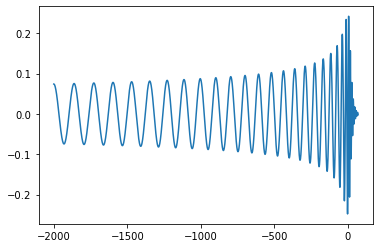

In [10]:
# plt.plot(StoM(hp.sample_times, total_mass), hp)
plt.plot(new_times_M, hp)

(-100.0, 120.0)

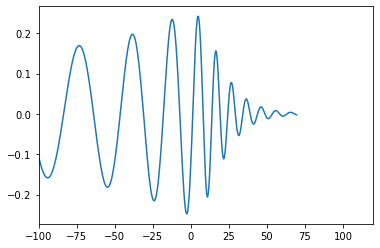

In [11]:
# plt.plot(StoM(hp.sample_times, total_mass), hp)
plt.plot(new_times_M, hp)
plt.xlim(-100, 120)

In [12]:
# for mass-ratio 5 there
# appears to be a discontinuity
# for spin1x ~ 0.86 or so
# which makes modelling and evaluating
# the model difficult because
# this discontinuity dominates the error

# mass-ratio 4 doesn't seem to have this issue so lets
# use this as the max-mass-ratio
# so we can reach 0.99 spins

In [13]:
np.pi/4*180/np.pi

45.0

In [14]:
3*np.pi/4*180/np.pi

135.0

In [15]:
4*np.pi/2/2/2

1.5707963267948966

In [16]:
np.pi/2

1.5707963267948966

In [17]:


# qs = np.arange(5, 5.1+0.05, 0.05)
# qs = np.linspace(1, 5, 20)
# chis = np.linspace(-0.99, 0.99, 20)
# chis = np.linspace(0, 0.99, 20)
# chis = np.linspace(0, 0.5, 20)

# chis_1 = np.linspace(0, 0.5, 20)
# chis_2 = np.linspace(0.5, 0.8, 40)
# chis = np.concatenate((chis_1, chis_2))


# chis = np.linspace(0.5, 0.7, 40)
# chis = np.linspace(0., 0.8, 40*2)
# chis = np.linspace(0.7, 0.9, 60)
# chis = np.linspace(0.7, 0.8, 40)

# chis = np.linspace(0.8, 0.99, 10)


# qs = np.linspace(1, 4, 40)
# chis = np.array([0.4])


# qs = np.array([1., 4.])
# qs = np.array([4.])
# qs = np.array([1.])
qs = np.array([3.])
# r_1_fixed = 0.99
r_1_fixed = 0.8
phi_1_fixed = 0.

theta_1s_1 = np.linspace(0, np.pi/8, 20)
theta_1s_2 = np.linspace(np.pi/8, 3*np.pi/8, 110)
theta_1s_3 = np.linspace(3*np.pi/8, 4*np.pi/8, 80)
theta_1s = np.concatenate((theta_1s_1, theta_1s_2, theta_1s_3))


XX, YY = np.meshgrid(qs, theta_1s)
XX = XX.ravel()
YY = YY.ravel()

In [18]:
qs

array([3.])

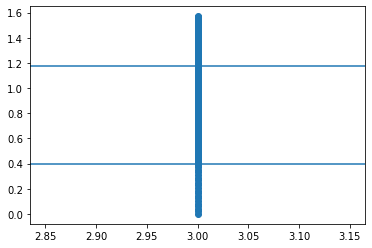

In [19]:
plt.scatter(XX, YY)
plt.axhline(np.pi/8)
plt.axhline(3*np.pi/8)

In [20]:
num_samples = len(XX)

In [21]:
num_samples

210

In [22]:
%%time
hps = []
for i in range(num_samples):
    mass_ratio = XX[i]
    theta_1 = YY[i]
    hp = generate_waveform(new_times_M=new_times_M, mass_ratio=mass_ratio, r_1=r_1_fixed, theta_1=theta_1, phi_1=phi_1_fixed, total_mass=total_mass, approximant=approximant, distance_mpc=distance_mpc)
    hps.append(hp)
hps = np.array(hps)

CPU times: user 3min 6s, sys: 2.04 s, total: 3min 8s
Wall time: 3min 8s


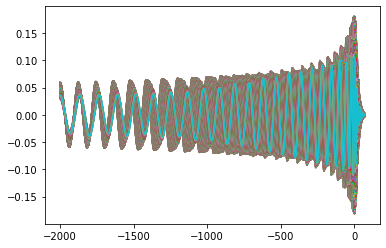

In [23]:
for hp in hps:
    plt.plot(new_times_M, hp)
# plt.xlim(-100, 100)

In [24]:
# for i, hp in enumerate(hps):
#     plt.plot(new_times_M, hp, label=chis[i])
# plt.xlim(-100, 100)
# # plt.yscale('log')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

(-100.0, 100.0)

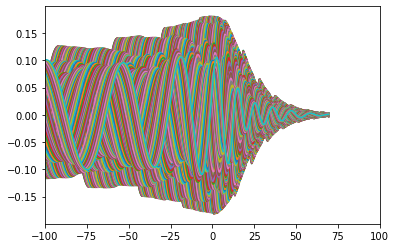

In [25]:
for hp in hps:
    plt.plot(new_times_M, hp)
plt.xlim(-100, 100)
# plt.yscale('log')

In [26]:
theta = np.column_stack((XX, YY))

In [27]:
theta_idxs = np.arange(len(theta))


# if you want the training set and validation set to have
# different mass-ratios then uncomment
theta_training_idxs = theta_idxs[::2]
# theta_training_idxs = theta_idxs[::3]


# the next lines are a bit confusing
# but 
# if you do q_idxs[1::2] then the last data point it outside the training set
# so for the training idxs I also add in the last data point
# that would have been totally excluded
theta_training_idxs = np.concatenate((theta_training_idxs, [theta_idxs[-1]]))
theta_validation_idxs = theta_idxs[1:-1:2]
# theta_validation_idxs = theta_idxs[1:-1:3]

# use this if you want the train and val sets to have the same mass-ratios
# but they will be using alternating time samples
# theta_training_idxs = theta_idxs
# theta_validation_idxs = theta_idxs

In [28]:
theta_training_idxs

array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
       130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
       182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206,
       208, 209])

In [29]:
theta_validation_idxs

array([  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,
        27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,
        53,  55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,
        79,  81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101, 103,
       105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129,
       131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155,
       157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181,
       183, 185, 187, 189, 191, 193, 195, 197, 199, 201, 203, 205, 207])

In [30]:
len(theta_idxs)

210

In [31]:

len(theta_training_idxs)


106

In [32]:

len(theta_validation_idxs)

104

Text(0.5, 1.0, 'theta train/val distribution')

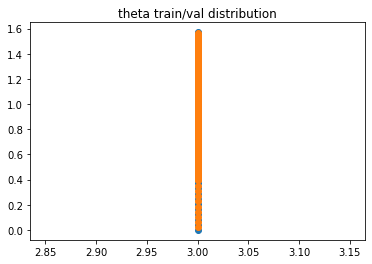

In [33]:
plt.figure()
plt.scatter(theta[theta_training_idxs,0], theta[theta_training_idxs,1])
plt.scatter(theta[theta_validation_idxs,0], theta[theta_validation_idxs,1])
plt.title("theta train/val distribution")

In [34]:
t_idxs = np.arange(len(new_times_M))
t_training_idxs = t_idxs[::2]
t_validation_idxs = t_idxs[1::2]

In [35]:
len(t_idxs)

4140

In [36]:
len(t_training_idxs)

2070

In [37]:
len(t_validation_idxs)

2070

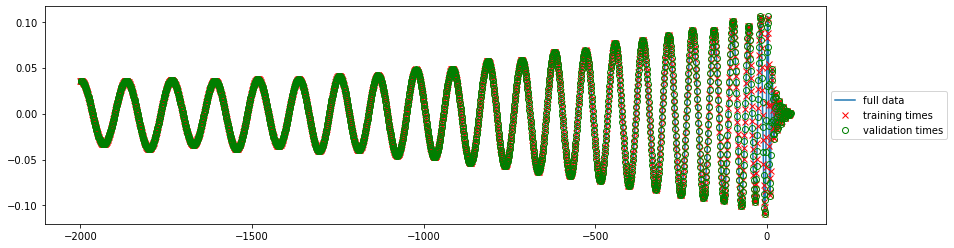

In [38]:
plt.figure(figsize=(14, 4))
plt.plot(new_times_M, hps[-1], label='full data')
plt.plot(new_times_M[t_training_idxs], hps[-1][t_training_idxs], 'rx', label='training times')
plt.plot(new_times_M[t_validation_idxs], hps[-1][t_validation_idxs], 'go',markerfacecolor='none', label='validation times')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

(-100.0, 100.0)

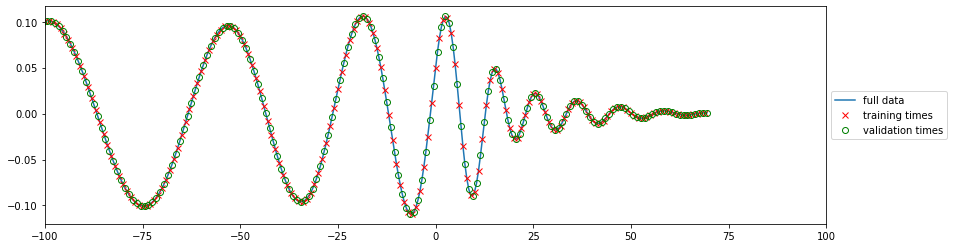

In [39]:
plt.figure(figsize=(14, 4))
plt.plot(new_times_M, hps[-1], label='full data')
plt.plot(new_times_M[t_training_idxs], hps[-1][t_training_idxs], 'rx', label='training times')
plt.plot(new_times_M[t_validation_idxs], hps[-1][t_validation_idxs], 'go',markerfacecolor='none', label='validation times')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(-100, 100)

In [40]:
def build_input_single_q(t, q, chi):
    """
    t is a matrix i.e. shape = (-1, 1)
    q is a float
    chi is a float
    """
    theta = np.array([q, chi])
    theta = np.ones_like(t) * theta

    return np.column_stack((t, theta))

In [41]:
build_input_single_q(np.array([1,2,3]).reshape(-1, 1), 1, 0.5)

array([[1. , 1. , 0.5],
       [2. , 1. , 0.5],
       [3. , 1. , 0.5]])

In [42]:
def build_input_multiple_q(t, thetas):
    """
    t is a vector
    thetas is a vector
    """
    return np.row_stack([build_input_single_q(t, *theta) for theta in thetas])

In [43]:
build_input_multiple_q(np.array([1,2,3]).reshape(-1, 1), [[1,3], [0.5, 0.4]])

array([[1. , 1. , 3. ],
       [2. , 1. , 3. ],
       [3. , 1. , 3. ],
       [1. , 0.5, 0.4],
       [2. , 0.5, 0.4],
       [3. , 0.5, 0.4]])

In [44]:
t_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))
theta_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))

t_scaled = t_scaler.fit_transform(new_times_M[:,np.newaxis])
theta_scaled = theta_scaler.fit_transform(theta)

In [45]:
hps_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))

hps_shape = hps.shape
hps_scaled = hps_scaler.fit_transform(hps.reshape(-1, 1)).reshape(hps_shape)

In [46]:
X_training = build_input_multiple_q(t_scaled[t_training_idxs], theta_scaled[theta_training_idxs])

In [47]:
X_validation = build_input_multiple_q(t_scaled[t_validation_idxs], theta_scaled[theta_validation_idxs])

In [48]:
X_training.shape

(219420, 3)

In [49]:
X_validation.shape

(215280, 3)

In [50]:
hps.shape

(210, 4140)

In [51]:
# y_training = hps[np.ix_(theta_training_idxs, t_training_idxs)]
# y_training = y_training.reshape(-1, 1)
# y_validation = hps[np.ix_(theta_validation_idxs, t_validation_idxs)]
# y_validation = y_validation.reshape(-1, 1)


# https://stackoverflow.com/questions/35607818/index-a-2d-numpy-array-with-2-lists-of-indices
y_training = hps_scaled[np.ix_(theta_training_idxs, t_training_idxs)]
y_training = y_training.reshape(-1, 1)
y_validation = hps_scaled[np.ix_(theta_validation_idxs, t_validation_idxs)]
y_validation = y_validation.reshape(-1, 1)

In [52]:
y_training.shape

(219420, 1)

In [53]:
y_validation.shape

(215280, 1)

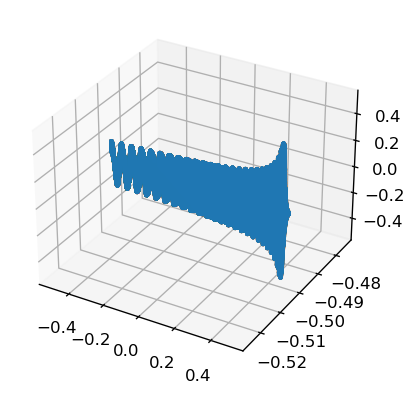

In [54]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot(projection='3d')
ax.scatter(X_training[:,0], X_training[:,1], y_training, s=3)
ax.scatter(X_validation[:,0], X_validation[:,1], y_validation, s=3)

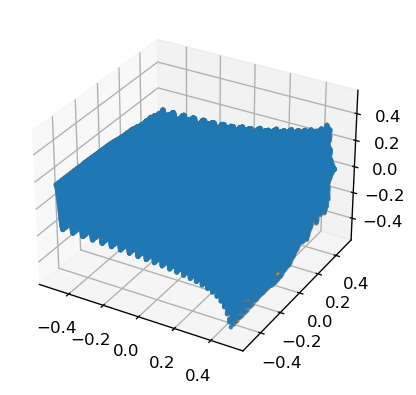

In [55]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot(projection='3d')
ax.scatter(X_training[:,0], X_training[:,2], y_training, s=3)
ax.scatter(X_validation[:,0], X_validation[:,2], y_validation, s=3)

In [56]:
64/4/4

4.0

In [57]:
def run_model(X_train, y_train, epochs=1001, threshold=1e-7, batch_size=32, validation_data=None, learning_rate=1e-3, verbose=0, model_version="1"):
    activation = 'relu'
    units = 256
    n_layers = 3
    # gaussian_projection = units
    gaussian_projection = 16
    # gaussian_projection = 5
    # gaussian_scale = 1

    # gaussian_scale = 50
    # gaussian_scale = 20
    # gaussian_scale = 10
    # gaussian_scale = 5
    # gaussian_scale = 16
    # gaussian_scale = 64/4
    # gaussian_scale = 2 # -500
    # gaussian_scale = 2*4 # -2000
    # gaussian_scale = 32 # -2000    
    
    
    # gaussian_scale = 40 # -2000       
    # gaussian_scale = 40/4 # -500
    # gaussian_scale = 40/10 # -200
    
    
    # gaussian_scale = 5 # -200
    # gaussian_scale = 5*4 # -2000
    gaussian_scale = 5*6 # -2000    
    
    # gaussian_scale = 2*4*2 # -2000, high spin
    # gaussian_scale = 2*4*2*2 # -2000, higher spin
    # gaussian_scale = 2*4*2*2*2

    # model 1: only pass the time through the RFF encoding
    time_input = tf.keras.Input(shape=(1,), name='time_input')
    # q_input = tf.keras.Input(shape=(1,), name='q_input')
    theta_input = tf.keras.Input(shape=(2,), name='theta_input')
    x_t = FourierFeatureProjection(gaussian_projection = gaussian_projection, gaussian_scale = gaussian_scale)(time_input)
    
    
    if model_version == "1":
        # x = tf.keras.layers.Concatenate()([x_t, q_input])
        x = tf.keras.layers.Concatenate()([x_t, theta_input])
    elif model_version == "2":
        # x_q = FourierFeatureProjection(gaussian_projection = 5, gaussian_scale = 0.1)(q_input)
        # x_theta = FourierFeatureProjection(gaussian_projection = 16, gaussian_scale = 0.3)(theta_input)
        x_theta = FourierFeatureProjection(gaussian_projection = 16, gaussian_scale = 2)(theta_input)
        # x = tf.keras.layers.Concatenate()([x_t, x_q])
        x = tf.keras.layers.Concatenate()([x_t, x_theta])
    else:
        raise ValueError()
    
    # x_q = tf.keras.layers.Dense(units, activation)(q_input)

    for i in range(n_layers):
        x = tf.keras.layers.Dense(units, activation)(x)
    x = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=[time_input, theta_input], outputs=x)

    # model 2: pass both time and mass-ratio through RFF encoding
    # model 2 doesn't work so well in the q-direction :)
    # I am guessing it's because the variation of the function in q
    # is simpler than the variation in time.
    # time_input = tf.keras.Input(shape=(1,), name='time_input')
    # q_input = tf.keras.Input(shape=(1,), name='q_input')
    # all_inputs = tf.keras.layers.Concatenate()([time_input, q_input])
    # x = FourierFeatureProjection(gaussian_projection = gaussian_projection, gaussian_scale = gaussian_scale)(all_inputs)
    # # x_q = tf.keras.layers.Dense(units, activation)(q_input)
    # # x = tf.keras.layers.Concatenate()([x_t, q_input])
    # # x = tf.keras.layers.Concatenate()([x_t, x_q])
    # for i in range(n_layers):
    #     x = tf.keras.layers.Dense(units, activation)(x)
    # x = tf.keras.layers.Dense(1)(x)
    # model = tf.keras.Model(inputs=[time_input, q_input], outputs=x)
    
    callbacks = [
        # tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(threshold),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.9, monitor='val_loss'),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.6, monitor='val_loss'),
        tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=80, factor=0.2, monitor='val_loss'),        
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.1, monitor='val_loss'),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300),
    ]
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate))

    history = model.fit(x=[X_train[:,0], X_train[:,1:]], y=y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data)
    
    return history, model

In [58]:
X_training.shape

(219420, 3)

In [59]:
# epochs=2000
# epochs=200
epochs=300
batch_size = 512
# batch_size = 2048
print(batch_size)

learning_rate = 1e-3
# learning_rate = 1e-4
print(learning_rate)

512
0.001


In [60]:
# model_version="1"
model_version="2"

In [61]:
%%time
history, model = run_model(
    X_training,
    y_training,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=([X_validation[:,0], X_validation[:,1:]], y_validation),
    learning_rate=learning_rate,
    threshold=1e-7,
    verbose=1,
    model_version=model_version,
    # threshold=3e-6
    )

Metal device set to: Apple M1 Pro
Epoch 1/300


2022-06-29 14:31:54.728018: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-29 14:31:54.728131: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-29 14:31:54.839168: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  8/429 [..............................] - ETA: 3s - loss: 0.0836  

2022-06-29 14:31:55.053133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - ETA: 0s - loss: 0.0064

2022-06-29 14:31:58.806636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - 6s 13ms/step - loss: 0.0064 - val_loss: 0.0010 - lr: 0.0010
Epoch 2/300
429/429 [==============================] - 5s 12ms/step - loss: 7.9588e-04 - val_loss: 5.4684e-04 - lr: 0.0010
Epoch 3/300
429/429 [==============================] - 5s 12ms/step - loss: 4.9831e-04 - val_loss: 4.0383e-04 - lr: 0.0010
Epoch 4/300
429/429 [==============================] - 5s 12ms/step - loss: 3.7128e-04 - val_loss: 2.5966e-04 - lr: 0.0010
Epoch 5/300
429/429 [==============================] - 5s 12ms/step - loss: 2.7924e-04 - val_loss: 2.9056e-04 - lr: 0.0010
Epoch 6/300
429/429 [==============================] - 5s 12ms/step - loss: 2.7241e-04 - val_loss: 3.2246e-04 - lr: 0.0010
Epoch 7/300
429/429 [==============================] - 5s 12ms/step - loss: 2.4736e-04 - val_loss: 2.1662e-04 - lr: 0.0010
Epoch 8/300
429/429 [==============================] - 5s 12ms/step - loss: 2.4189e-04 - val_loss: 2.5900e-04 - lr: 0.0010
Epoch 9/300
429/429 [===============

In [62]:
# 57 epochs
# 8 mins

# loss = 8e-7
# val loss = 1e-6

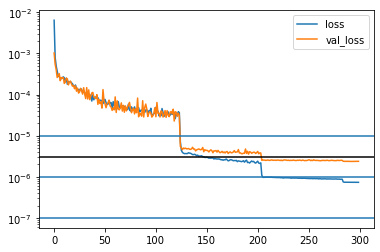

In [63]:
plt.figure()
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.axhline(1e-5)
plt.axhline(1e-6)
plt.axhline(3e-6, c='k')
plt.axhline(1e-7)
plt.yscale("log")


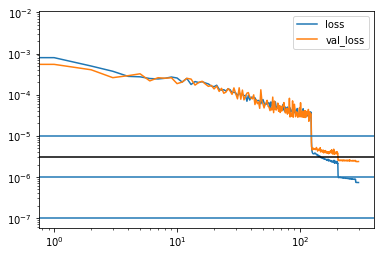

In [64]:
plt.figure()
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.axhline(1e-5)
plt.axhline(1e-6)
plt.axhline(3e-6, c='k')
plt.axhline(1e-7)

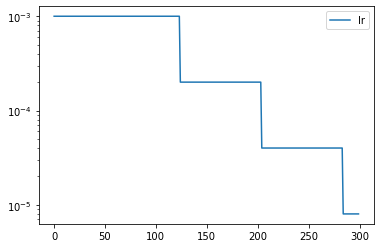

In [65]:
try:
    plt.figure()
    plt.plot(history.history["lr"], label='lr')
    plt.legend()
    plt.yscale("log")
    # plt.xscale("log")
except:
    pass

In [66]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 theta_input (InputLayer)       [(None, 2)]          0           []                               
                                                                                                  
 fourier_feature_projection (Fo  (None, 32)          16          ['time_input[0][0]']             
 urierFeatureProjection)                                                                          
                                                                                                  
 fourier_feature_projection_1 (  (None, 32)          32          ['theta_input[0][0]']        

In [67]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [68]:
model.layers

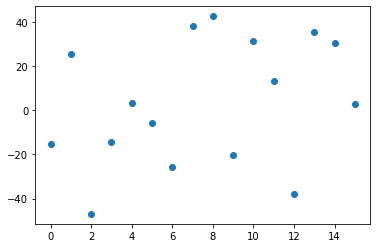

In [69]:
try:
    w=model.layers[1].weights[0].numpy()[0]
except:
    w=model.layers[2].weights[0].numpy()[0]
plt.scatter(range(len(w)), w)

In [70]:
test_input = build_input_single_q(t_scaled, *theta_scaled[theta_validation_idxs[-1]])
# test_yhat = model.predict([test_input[:,0], test_input[:,1:]], verbose=0)
test_yhat = model([test_input[:,0], test_input[:,1:]])

In [71]:
test_input.shape

(4140, 3)

In [72]:
%%timeit
# model.predict([test_input[:,0], test_input[:,1:]], verbose=0)
model([test_input[:,0], test_input[:,1:]])

9.94 ms ± 85.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


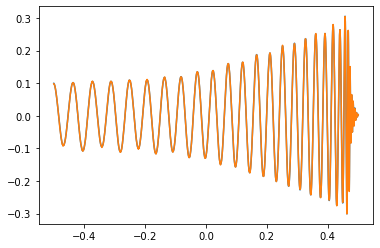

In [73]:
plt.plot(test_input[:,0], hps_scaled[theta_validation_idxs[-1]])
plt.plot(test_input[:,0], test_yhat[:,0], ls='-')
# plt.xlim(0.3, 0.5)
# plt.yscale('log')

(0.3, 0.5)

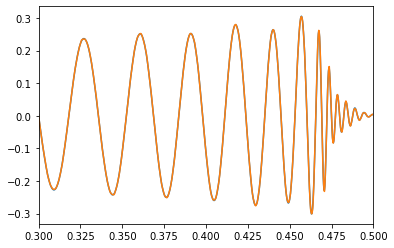

In [74]:
plt.plot(test_input[:,0], hps_scaled[theta_validation_idxs[-1]])
plt.plot(test_input[:,0], test_yhat[:,0], ls='-')
plt.xlim(0.3, 0.5)
# plt.yscale('log')

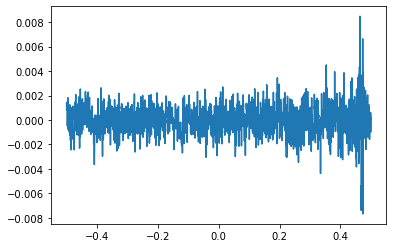

In [75]:
plt.plot(test_input[:,0], hps_scaled[theta_validation_idxs[-1]]-test_yhat[:,0])
# plt.xlim(0.3, 0.5)
# plt.yscale('log')

In [76]:
tf.keras.losses.mean_squared_error(hps_scaled[theta_validation_idxs[-1]], test_yhat[:,0])

<tf.Tensor: shape=(), dtype=float32, numpy=1.2194744e-06>

In [77]:
theta_validation_idxs.shape

(104,)

In [78]:
t_validation_idxs.shape

(2070,)

In [79]:
np.mean((hps_scaled[theta_validation_idxs[-1]]-test_yhat[:,0])**2)

1.219475e-06

In [80]:
# yhat_train = model.predict([X_training[:,0], X_training[:,1:]], verbose=0)
yhat_train = model([X_training[:,0], X_training[:,1:]])

shape_ = (theta_training_idxs.shape[0], t_training_idxs.shape[0])
print(shape_)

# yhat_train = yhat_train.reshape(shape_)
yhat_train = yhat_train.numpy().reshape(shape_)

(106, 2070)


In [81]:
mse_train = tf.keras.losses.mean_squared_error(y_training.reshape(shape_), yhat_train)

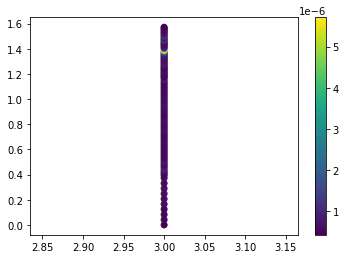

In [82]:
plt.figure()
plt.scatter(theta[theta_training_idxs,0], theta[theta_training_idxs,1], c=mse_train)
plt.colorbar()

In [83]:
worst_idx = np.argmax(mse_train)
worst_idx

86

(-100.0, 120.0)

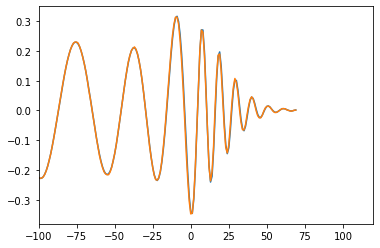

In [84]:
plt.figure()
plt.plot(new_times_M[t_training_idxs], y_training.reshape(shape_)[worst_idx])
plt.plot(new_times_M[t_training_idxs], yhat_train[worst_idx])
plt.xlim(-100, 120)

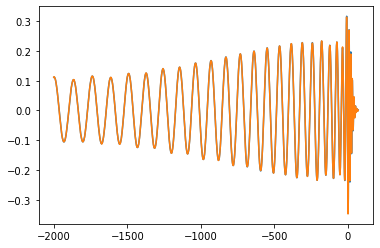

In [85]:
plt.figure()
plt.plot(new_times_M[t_training_idxs], y_training.reshape(shape_)[worst_idx])
plt.plot(new_times_M[t_training_idxs], yhat_train[worst_idx])
# plt.xlim(-100, 100)

In [86]:
# yhat_val = model.predict([X_validation[:,0], X_validation[:,1:]], verbose=0)
yhat_val = model([X_validation[:,0], X_validation[:,1:]])

shape_ = (theta_validation_idxs.shape[0], t_validation_idxs.shape[0])
print(shape_)

# yhat_val = yhat_val.reshape(shape_)
yhat_val = yhat_val.numpy().reshape(shape_)

(104, 2070)


In [87]:
theta_validation_idxs.shape

(104,)

In [88]:
hps_scaled.shape

(210, 4140)

In [89]:
mse_val = tf.keras.losses.mean_squared_error(y_validation.reshape(shape_), yhat_val)

In [90]:
theta.shape

(210, 2)

In [91]:
worst_idx = np.argmax(mse_val)
worst_idx

4

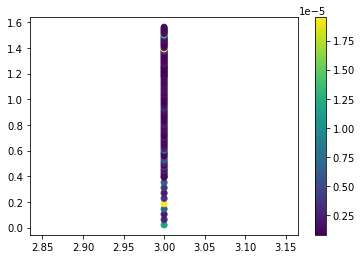

In [92]:
plt.figure()
plt.scatter(theta[theta_validation_idxs,0], theta[theta_validation_idxs,1], c=mse_val)
plt.colorbar()

In [93]:
yhat_val.shape

(104, 2070)

In [94]:
theta[theta_validation_idxs][worst_idx]

array([3.        , 0.18601535])

In [95]:
theta[theta_validation_idxs][-1]

array([3.        , 1.56085458])

In [96]:
theta[theta_validation_idxs][worst_idx-1]

array([3.        , 0.14467861])

(-100.0, 120.0)

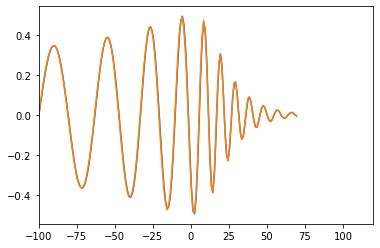

In [97]:
plt.figure()
plt.plot(new_times_M[t_validation_idxs], y_validation.reshape(shape_)[worst_idx])
plt.plot(new_times_M[t_validation_idxs], yhat_val[worst_idx])
plt.xlim(-100, 120)

(-500.0, 120.0)

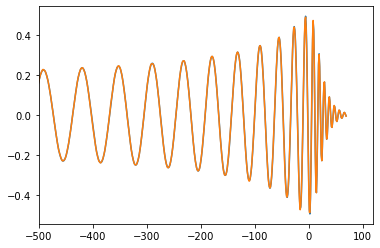

In [98]:
plt.figure()
plt.plot(new_times_M[t_validation_idxs], y_validation.reshape(shape_)[worst_idx])
plt.plot(new_times_M[t_validation_idxs], yhat_val[worst_idx])
plt.xlim(-500, 120)

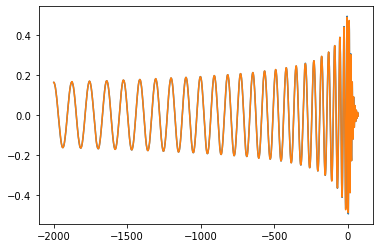

In [99]:
plt.figure()
plt.plot(new_times_M[t_validation_idxs], y_validation.reshape(shape_)[worst_idx])
plt.plot(new_times_M[t_validation_idxs], yhat_val[worst_idx])
# plt.xlim(-100, 100)

In [100]:
worst_idx

4

(-100.0, 120.0)

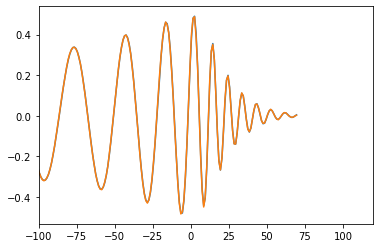

In [101]:
plt.figure()
plt.plot(new_times_M[t_validation_idxs], y_validation.reshape(shape_)[17])
plt.plot(new_times_M[t_validation_idxs], yhat_val[17])
plt.xlim(-100, 120)

In [102]:
StoM(1/4096, 60)

0.8261126445190531

In [103]:
StoM(1/2048, 60)

1.6522252890381062

In [104]:
# test_input = build_input_single_q(t_scaled, *theta_scaled[theta_validation_idxs[-1]])
test_input = build_input_single_q(t_scaler.transform(np.arange(-10000, 100, 1.65)[:,np.newaxis]), *theta_scaled[theta_validation_idxs[-1]])

In [105]:
test_input.shape

(6122, 3)

In [106]:
%%timeit
model.predict([test_input[:,0], test_input[:,1:]], verbose=0)

2022-06-29 14:58:38.209257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


714 ms ± 5.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [107]:
%%timeit
model([test_input[:,0], test_input[:,1:]])

10.8 ms ± 205 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [108]:
@tf.function
def run_inference(test_input):
    return model([test_input[:,0], test_input[:,1:]])

In [109]:
@tf.function(jit_compile=None, reduce_retracing=True)
def run_inference_exp_comp(test_input):
    return model([test_input[:,0], test_input[:,1:]])

In [110]:
%%timeit
run_inference(test_input)

2022-06-29 14:58:52.754442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6.47 ms ± 241 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [111]:
%%time
_ = run_inference(test_input)

CPU times: user 3.82 ms, sys: 3.47 ms, total: 7.29 ms
Wall time: 5.38 ms


In [112]:
%%timeit
run_inference_exp_comp(test_input)

2022-06-29 14:58:58.088862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6.43 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [113]:
%%time
_ = run_inference_exp_comp(test_input)

CPU times: user 4.23 ms, sys: 4.86 ms, total: 9.08 ms
Wall time: 6.04 ms


In [114]:
npts = 20
# qs_ = np.array([4]*npts)
# qs_ = np.array([1]*npts)
qs_ = np.array([3]*npts)
# chis_ = np.linspace(0, 0.99, npts)
theta_ = np.linspace(0, np.pi/2, npts)
# chis_ = np.array([0.99])

In [115]:
# t_test_M = np.arange(-2000, 120, 0.5)[:,np.newaxis]
t_test_M = np.arange(-2000, 70, 0.5)[:,np.newaxis]
# t_test_M = np.arange(-200, 70, 0.5)[:,np.newaxis]
t_test_sc = t_scaler.transform(t_test_M)

In [116]:
X_test_scaled = build_input_multiple_q(t_test_sc, theta_scaler.transform(np.array([qs_, theta_]).T))

In [117]:
y_test_scaled = model([X_test_scaled[:,0], X_test_scaled[:,1:]])

In [118]:
y_test_scaled.shape

TensorShape([82800, 1])

In [119]:
X_test_scaled.shape

(82800, 3)

In [120]:
shape_ = (npts, t_test_sc.shape[0])

In [121]:
y_test_scaled = y_test_scaled.numpy().reshape(shape_)

In [122]:
y_test_scaled.shape

(20, 4140)

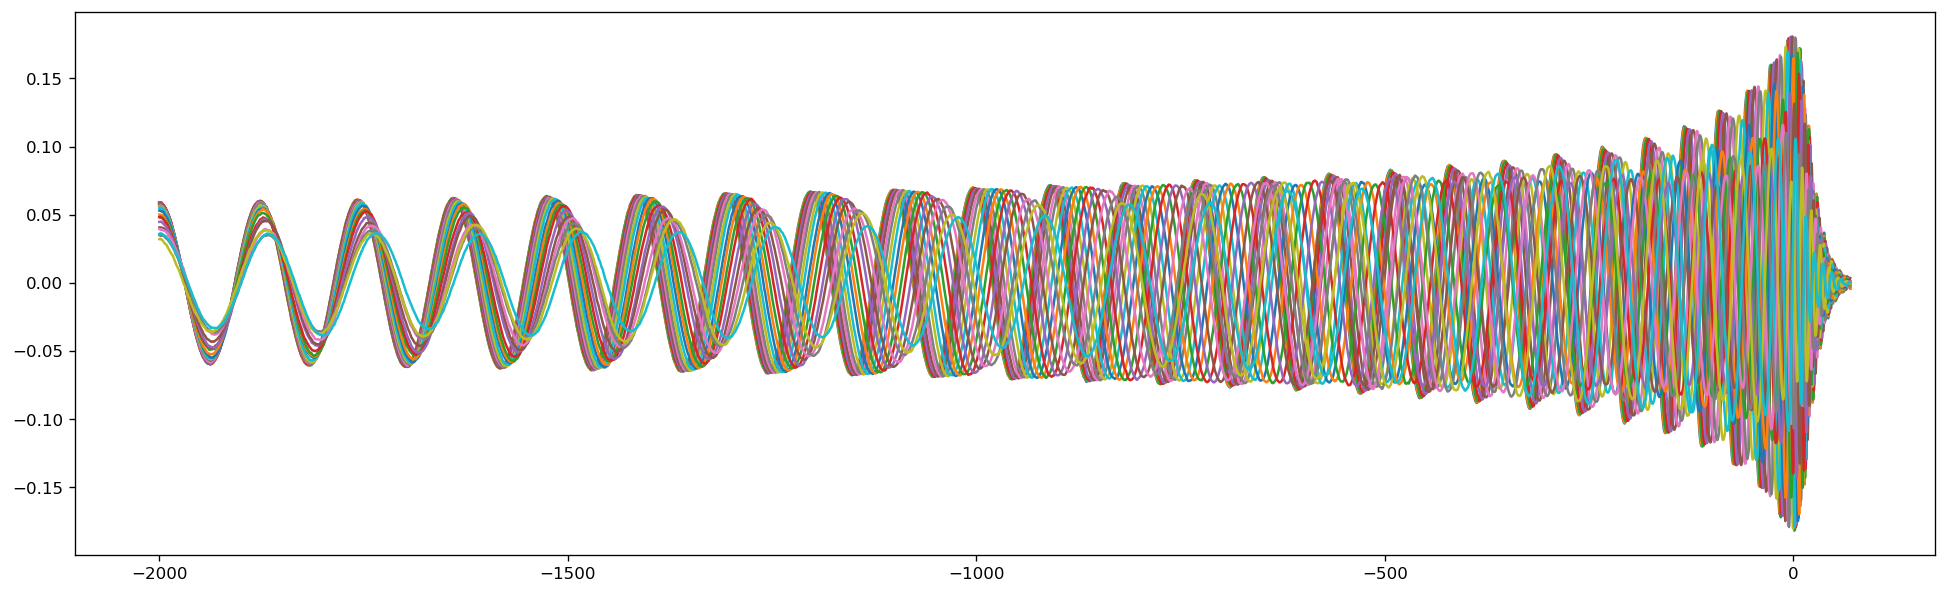

In [123]:
plt.figure(figsize=(20, 6), dpi=120)
for y_test_sc in y_test_scaled:
    plt.plot(t_test_M, hps_scaler.inverse_transform(y_test_sc[:,np.newaxis]))
# plt.xlim(-100, 100)
# plt.ylim(0.01, 0.3)
# plt.yscale('log')

(-100.0, 120.0)

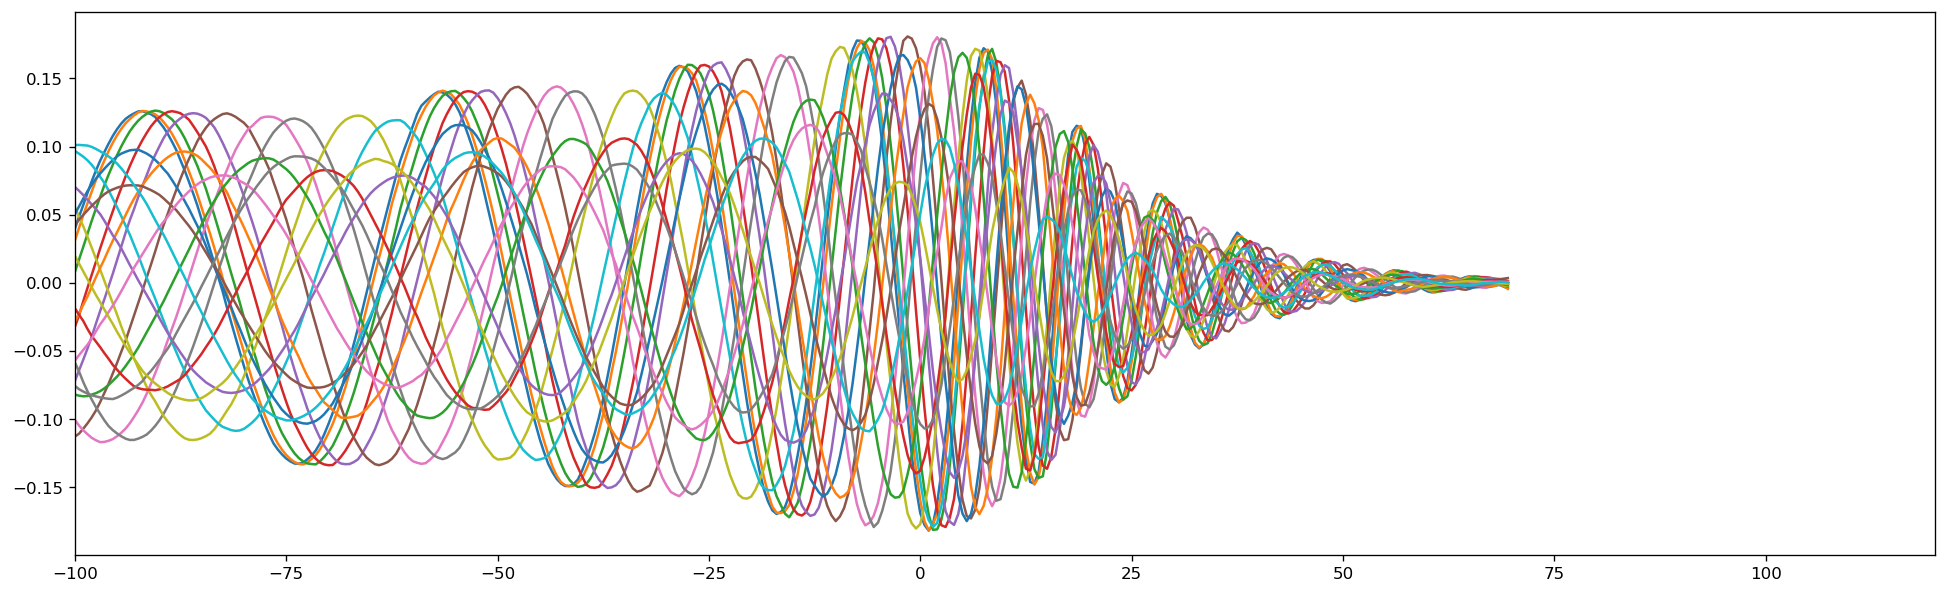

In [124]:
plt.figure(figsize=(20, 6), dpi=120)
for y_test_sc in y_test_scaled:
    plt.plot(t_test_M, hps_scaler.inverse_transform(y_test_sc[:,np.newaxis]))
plt.xlim(-100, 120)
# plt.ylim(0.01, 0.3)
# plt.yscale('log')